# Clustering Test

In [97]:
import pandas as pd
import numpy as np
import concurrent.futures as cf
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

pd.set_option('display.max_columns', None)

%matplotlib inline

In [100]:
%%time

df = pd.read_csv('/Volumes/LaCie SSD/bgdata/random_data/all_years_rand_samp.csv', parse_dates=['JobDate'], low_memory=False)
df.head()

CPU times: user 19.3 s, sys: 20.4 s, total: 39.7 s
Wall time: 1min 4s


,Language,CanonCity,CanonState,CleanJobTitle,JobDate,JobText,JobID,Latitude,Longitude,CanonPostalCode,CanonCounty,DivisionCode,LMA,MSA,CanonEmployer,CanonJobTitle,ConsolidatedONET,CanonIntermediary,InternshipFlag,Source,CanonSkillClusters,CanonSkills,IsDuplicate,CanonMinimumDegree,CanonRequiredDegrees,CIPCode,MinExperience,ConsolidatedInferredNAICS,BGTOcc,MaxAnnualSalary,MaxHourlySalary,MinAnnualSalary,MinHourlySalary,CanonJobHours,CanonJobType,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,ConsolidatedDegreeLevels,ConsolidatedTitle,MaxDegreeLevel,MinDegreeLevel,BGTSubOcc,YearsOfExperience
0,en,Irvine,CA,Pt Faculty Pool - Recycling & Zero Waste,2013-01-03,Posting Details South Orange County Community ...,110103522,33.6881,-117.7880,92604,Orange,11244.0,DV064204|MT063110,31080: Metropolitan Statistical Area|348: Comb...,Saddleback College,NaN,25-119900,NaN,0,Education,Education and Training: Instructional and Curr...,{'Course Development': 'Education and Training...,False,Bachelor of Arts,Bachelor of Arts|Bachelor's|Master's,030103,6.0,6113.0,25-1199.91,NaN,NaN,NaN,NaN,fulltime,permanent,1-6,mid,16|18,Pt Faculty Pool - Recycling & Zero Waste,18.0,16.0,College Professor / Instructor,2) years|6) years|Two years
1,en,Marbury,MD,Class A Cdl Truck Driver,2013-11-20,Experienced Class A CDL Truck Drivers (20658),255851194,38.5624,-77.1639,20658,Charles,47894.0,DV114789|MT114790,47900: Metropolitan Statistical Area|548: Comb...,Usa Truck,Class A CDL Truck Driver,53-303200,NaN,0,Job Board,NaN,{},False,NaN,NaN,NaN,NaN,484.0,53-3032.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Class A CDL Truck Driver,NaN,NaN,Tractor-Trailer Truck Driver (General),NaN
2,en,Auburn,AL,Apartment Community Maintenance Technician - S...,2013-09-06,"Posted: 2013-09-05, 4:16PM EDT\n\nApartment Co...",246911326,32.5824,-85.5126,36830,Lee,NaN,MT011222,12220: Metropolitan Statistical Area,NaN,Maintenance Technician,49-907100,NaN,0,FreeJobBoard,"Maintenance, Repair, and Installation: HVAC;Sp...","{'HVAC': 'Maintenance, Repair, and Installatio...",False,Higher Secondary Certificate,Higher Secondary Certificate,NaN,2.0,NaN,49-9071.91,NaN,NaN,NaN,NaN,NaN,NaN,1-6,mid,12,Maintenance Technician,NaN,12.0,Building and General Maintenance Technician,minimum of six months|two years
3,en,Anchorage,AK,Registered Nurse - All Specialties And Shifts,2013-08-30,Description:\n* Registered Nurses - All Spec...,244857419,61.2157,-149.8690,99501,Anchorage,NaN,MT021126,11260: Metropolitan Statistical Area,Nadiagruzd,Registered Nurse,29-114100,NaN,0,Recruiter,NaN,{},False,NaN,NaN,NaN,NaN,62.0,29-1141.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Registered Nurse,NaN,NaN,Registered Nurse,NaN
4,en,Madison,WI,Project Manager,2013-11-30,"Apex Systems, Inc Skills: Project ma...",420796045,43.1153,-89.5249,53562,Dane,NaN,MT553154,31540: Metropolitan Statistical Area,NaN,NaN,15-119909,"Apex Systems, Inc.",0,Job intermediary,Finance: Cost Accounting;Specialized Skills|Ma...,{'Cost Analysis': 'Finance: Cost Accounting;Sp...,False,NaN,NaN,NaN,7.0,NaN,15-1199.95,NaN,NaN,NaN,NaN,fulltime,permanent,6+,high,NaN,Project Manager,NaN,NaN,IT Project Manager,7 years|5 years|3 years


# Data Inspection & Cleaning

In [101]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476428 entries, 0 to 476427
Data columns (total 43 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Language                          476428 non-null  object        
 1   CanonCity                         466244 non-null  object        
 2   CanonState                        476394 non-null  object        
 3   CleanJobTitle                     476269 non-null  object        
 4   JobDate                           476428 non-null  datetime64[ns]
 5   JobText                           473483 non-null  object        
 6   JobID                             476428 non-null  int64         
 7   Latitude                          466253 non-null  float64       
 8   Longitude                         466253 non-null  float64       
 9   CanonPostalCode                   465000 non-null  object        
 10  CanonCounty                     

In [102]:
df.shape

(476428, 43)

In [103]:
missing_pct = df.isna().sum() / df.shape[0] * 100
missing_pct

Language                             0.000000
CanonCity                            2.137574
CanonState                           0.007136
CleanJobTitle                        0.033373
JobDate                              0.000000
JobText                              0.618142
JobID                                0.000000
Latitude                             2.135685
Longitude                            2.135685
CanonPostalCode                      2.398684
CanonCounty                          2.159403
DivisionCode                        68.090666
LMA                                  2.479073
MSA                                  4.781625
CanonEmployer                       36.437405
CanonJobTitle                       35.178453
ConsolidatedONET                     3.593618
CanonIntermediary                   85.666040
InternshipFlag                       0.000000
Source                               3.168789
CanonSkillClusters                   8.660700
CanonSkills                       

A lot of the missing values in the `CanonEmployer` variable might be missing due to the job being posted through a recruiting agency. Let's see how many of these missing value have a value available in the `CanonIntermediary` column.

In [104]:
df.loc[(df['CanonEmployer'].isna()) & (df['CanonIntermediary'].notna()), :].shape

(68284, 43)

As we can see, about ~68,000 missing values in `CanonEmployer` have a matching Recruiting Agency in `CanonIntermediary`.

In [105]:
df.loc[(df['CanonEmployer'].isna()) & (df['CanonIntermediary'].notna()), ['CanonEmployer', 'CanonIntermediary']].head()

,CanonEmployer,CanonIntermediary
4,NaN,"Apex Systems, Inc."
10,NaN,Nigel Frank International
12,NaN,Kelly Services
20,NaN,Elance
31,NaN,Randstad


In [106]:
df.shape[0] * .15

71464.2

We can also see that the `CanonIntermediary` variable has about `0.15` of non-missing values in it, which is almost the same amount of values missing in the `CanonEmployer` var. Instead of filling in each missing value `CanonEmployer` with its respective recruiting agency for that title, what we will do instead is to fill in those missing values with the title, `Recruiting Agency`.

In [107]:
print(f'Missing companies BEFORE adding the Recruitment Agencies: {df.CanonEmployer.isna().sum()}')

Missing companies BEFORE adding the Recruitment Agencies: 173598


In [108]:
df.loc[(df['CanonEmployer'].isna()) & (df['CanonIntermediary'].notna()), 'CanonEmployer'] = 'Recruiting Agency'

In [109]:
print(f'Missing companies AFTER adding the Recruitment Agencies: {df.CanonEmployer.isna().sum()}')

Missing companies AFTER adding the Recruitment Agencies: 105314


In [110]:
print('Amount of Unique Employers: ', len(df['CanonEmployer'].unique()))

Amount of Unique Employers:  75805


In [111]:
# to_drop_cols = (missing_pct[missing_pct > 75]).index
# print(to_drop_cols)
# df.drop(to_drop_cols, axis=1, inplace=True)
# print(df.shape)

In [112]:
print('Amount of Unique Jobs: ', len(df['CleanJobTitle'].unique()))

Amount of Unique Jobs:  271225


In [113]:
print('Percentage of Unique Jobs in the Dataset: %.2f' % (len(df['CleanJobTitle'].unique()) / df.shape[0] * 100))

Percentage of Unique Jobs in the Dataset: 56.93


In [114]:
df['year'] = df['JobDate'].dt.year
print("Observations per Year")
df.groupby('year')['year'].count()

Observations per Year


year
2007    47695
2010    40487
2011    50144
2012    49926
2013    25631
2014    33690
2015    40945
2016    43376
2017    39534
2018    35000
2019    35000
2020    35000
Name: year, dtype: int64

# More Cleaning

In [115]:
df = df[df['CanonEmployer'].notna()]
df = df[df['JobText'].notna()]
df = df[df['CleanJobTitle'].notna()]

In [116]:
df.shape

(368555, 44)

In [117]:
df['clean_text'] = df['JobText'].apply(lambda x: ' '.join(list(filter(None, x.split('\n')))))
df['charac_text_len'] = df['clean_text'].apply(len)
df['low_clean'] = df['clean_text'].apply(lambda x: x.lower())

In [118]:
df['list_job_text'] = df['clean_text'].apply(lambda x: list(filter(None, x.split())))

In [119]:
df['len_job_text'] = df['list_job_text'].apply(len)

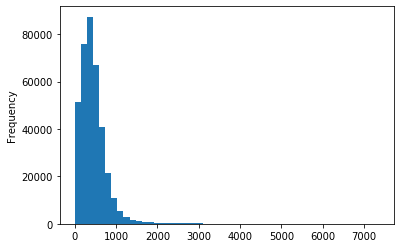

In [120]:
df['len_job_text'].plot(kind='hist', bins=50)

In [121]:
df['len_job_text'].describe()

count    368555.000000
mean        442.574134
std         336.774133
min           1.000000
25%         233.000000
50%         391.000000
75%         578.000000
max        7370.000000
Name: len_job_text, dtype: float64

In [122]:
df = df.loc[df['len_job_text'] > 75]
df.shape

(342332, 49)

In [123]:
df['len_job_text'].describe()

count    342332.000000
mean        474.721735
std         327.921201
min          76.000000
25%         269.000000
50%         413.000000
75%         595.000000
max        7370.000000
Name: len_job_text, dtype: float64

# Select Random Sample of 100K

In [124]:
df = df.sample(n=100000)
df = df[['JobDate', 'CanonEmployer', 'CleanJobTitle', 'clean_text']]
df.reset_index(drop=True, inplace=True)
df.head()

,JobDate,CanonEmployer,CleanJobTitle,clean_text
0,2010-11-17,Itech United States,Lsf 0 Administrator,Skills: Lawson LSF 9.0 Administrator Date: 11-...
1,2020-04-02,Indianapolis Power Light Company,Pd-Engineering Drafter,"PD-Engineering Drafter-002060 US, Indianapolis..."
2,2017-02-08,Recruiting Agency,Accounting Assistant,"Acounting Assistant Accountemps Redlands, CA 2..."
3,2011-02-26,Recruiting Agency,Sap Abap Consultant,RJT Compuquest provides ERP management consult...
4,2015-10-07,Recruiting Agency,Development With Angular Js - Outsource Com,Development with angular.js (Portland) - Outso...
